<a href="https://colab.research.google.com/github/Parimala-15/Brainwave_Matrix_Intern_AI-ML/blob/main/Text_Image_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text to Image Generation using Stable Diffusion and Diffusers

This cell installs the `glide-text2im` library directly from its GitHub repository. This library is necessary for running the GLIDE text-to-image model. The `!pip install git+...` command is a shell command executed within the Colab environment to fetch and install the package.

In [1]:
# This cell installs the `glide-text2im` library directly from its GitHub repository.
# This library is necessary for running the GLIDE text-to-image model.
# The `!pip install git+...` command is a shell command executed within the Colab environment
# to fetch and install the package.
!pip install git+https://github.com/openai/glide-text2im

  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-pe2yg41k
  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im /tmp/pip-req-build-pe2yg41k
  Resolved https://github.com/openai/glide-text2im to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [10]:
# This cell imports the `torch.nn.functional` module, commonly aliased as `F`.
# This module contains various functions for neural network operations,
# including interpolation which is used later for upscaling images.
import torch.nn.functional as F

In [2]:
# This cell imports necessary libraries:
# - PIL (Pillow): For image manipulation and display.
# - IPython.display: For displaying images directly within the notebook output.
# - torch as th: The main PyTorch library for tensor operations and deep learning models.
# - Modules from glide_text2im: These are specific components of the GLIDE library
#   for creating the CLIP model, loading checkpoints, setting up the diffusion model,
#   and tokenizing text.
from PIL import Image
from IPython.display import display
import torch as th
import torch.nn as nn
from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer

In [3]:
# This cell checks if a CUDA-enabled GPU is available and sets the `device` variable accordingly.
# If a GPU is found, it sets `device` to 'cuda', otherwise it sets it to 'cpu'.
# This is important for utilizing GPU acceleration if available, which significantly speeds up
# the image generation process. It then prints the selected device.
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')
print(device)

cuda


In [4]:
# This cell loads and configures the base GLIDE model.
# - model_and_diffusion_defaults(): Loads default settings for the base model.
# - options['use_fp16'] = has_cuda: Enables half-precision floating-point (FP16) if a CUDA GPU is available,
#   which can reduce memory usage and speed up computation.
# - options['timestep_respacing'] = '100': Configures the diffusion process to use 100 steps for sampling.
# - create_model_and_diffusion(**options): Creates the GLIDE model and diffusion object with the specified options.
# - model.eval(): Sets the model to evaluation mode.
# - model.convert_to_fp16(): Converts the model parameters to FP16 if use_fp16 is true.
# - model.to(device): Moves the model to the selected device (CPU or GPU).
# - model.load_state_dict(load_checkpoint('base', device)): Loads the pre-trained weights for the base GLIDE model.
# - The final line prints the total number of parameters in the base model.
# ✅ Load base model
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100'

model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))

print('✅ Total base parameters:', sum(p.numel() for p in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

✅ Total base parameters: 385030726


In [5]:
# This cell loads and configures the upsampling GLIDE model.
# - model_and_diffusion_defaults_upsampler(): Loads default settings for the upsampler model.
# - options_up['use_fp16'] = has_cuda: Enables FP16 for the upsampler if a CUDA GPU is available.
# - options_up['timestep_respacing'] = 'fast27': Configures the upsampling diffusion process to use a faster sampling schedule with 27 steps.
# - create_model_and_diffusion(**options_up): Creates the upsampler model and diffusion object.
# - model_up.eval(): Sets the upsampler model to evaluation mode.
# - model_up.convert_to_fp16(): Converts the upsampler model parameters to FP16 if use_fp16 is true.
# - model_up.to(device): Moves the upsampler model to the selected device.
# - model.load_state_dict(load_checkpoint('base', device)): Note: This line seems to load the base model checkpoint again into the base model,
#   not the upsampler model. It might be a copy-paste error and should likely load the 'upsample' checkpoint into model_up.
# - The final line prints the total number of parameters in the base model (again, likely intended to be the upsampler model).
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27'
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [6]:
# This function `show_images` is a helper function to display a batch of images inline.
# - It takes a PyTorch tensor `batch` as input.
# - It scales the pixel values from the model's output range (typically -1 to 1) to the 0-255 range for image display.
# - It then rearranges the tensor dimensions and reshapes it to create a single large image if there are multiple images in the batch.
# - Finally, it converts the tensor to a PIL Image and displays it using `IPython.display.display`.
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2,0,3,1).reshape([batch.shape[2],-1,3])
    display(Image.fromarray(reshaped.numpy()))

  0%|          | 0/100 [00:00<?, ?it/s]

✅ Base image shape: torch.Size([1, 3, 64, 64])
Value range: [-0.884, 1.000]


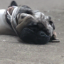

In [ ]:
# This cell demonstrates the base image generation process without upsampling.
# - It defines a prompt, batch_size, and guidance_scale.
# - It encodes the text prompt into tokens and creates a mask using the model's tokenizer.
# - It prepares the model_kwargs dictionary containing the tokens and mask, which are used as input to the model.
# - model.del_cache(): Clears any cached information in the model.
# - diffusion.p_sample_loop(...): This is the core diffusion process for generating the image.
#   It takes the model, the desired output shape (batch size, channels, image size), the device,
#   and other parameters like clip_denoised and model_kwargs. progress=True shows a progress bar.
#   cond_fn=None disables CLIP guidance.
# - model.del_cache(): Clears the cache again after generation.
# - It then prints the shape and value range of the generated base image and displays it
#   using the show_images function after clamping the values to the valid display range (-1 to 1).
# ✅ Simplified Base Image Generation Only
prompt = "pug dog"
batch_size = 1
guidance_scale = 3.0

# Encode text prompt
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(tokens, options['text_ctx'])

# Prepare model inputs
model_kwargs = {
    'tokens': th.tensor([tokens] * batch_size, device=device),
    'mask': th.tensor([mask] * batch_size, dtype=th.bool, device=device)
}

# Generate base image (64x64)
model.del_cache()
base_image = diffusion.p_sample_loop(
    model,
    (batch_size, 3, options['image_size'], options['image_size']),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None  # Disabled CLIP guidance for simplicity
)
model.del_cache()

# Verify and show only the base image
print(f"✅ Base image shape: {base_image.shape}")
print(f"Value range: [{base_image.min().item():.3f}, {base_image.max().item():.3f}]")
show_images(base_image.clamp(-1, 1))  # Ensures proper display range

🎨 Generating base image (64x64)...


  0%|          | 0/100 [00:00<?, ?it/s]

✅ Base image shape: torch.Size([1, 3, 64, 64])
🧪 Value range: [-0.941, 0.917]


/tmp/ipython-input-26-2246822626.py:59: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-26-2246822626.py:59: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-26-2246822626.py:59: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from fo

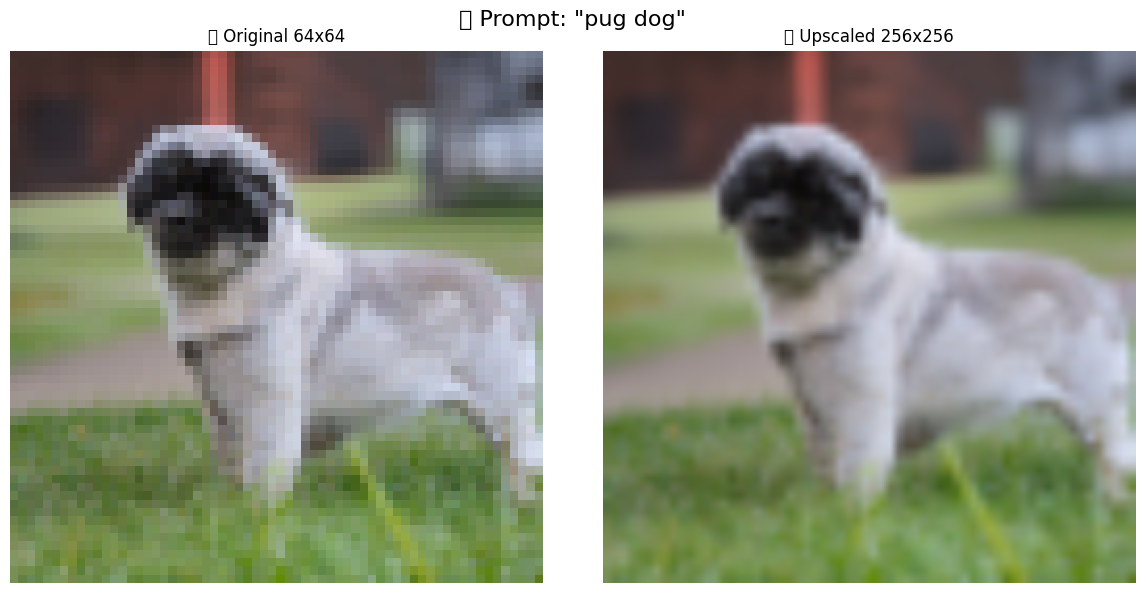

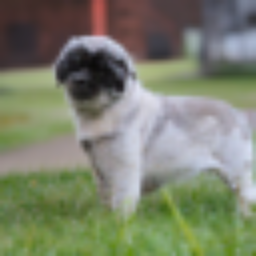

In [26]:
# This cell attempts to generate a base image, upscale it using bilinear interpolation,
# and display both the original and upscaled versions using matplotlib.
# - It defines configuration parameters like prompt, batch_size, guidance_scale, and display_size.
# - It performs the same prompt encoding and base image generation as the previous cell.
# - It then clamps the base image values to [-1, 1] and uses F.interpolate to upsample it
#   to the specified display_size using bilinear interpolation.
# - The to_image function is defined to convert the tensor format to a displayable image format
#   and normalize values to [0, 1].
# - It uses matplotlib.pyplot to create a figure with two subplots, displaying the original 64x64 image and the upscaled image.
# - It adds titles and a main title to the plot and displays it.
# - It also attempts to display the upscaled image inline using show_images.
# - The error output indicates warnings about missing glyphs for emojis in the plot titles,
#   but the code otherwise executed and displayed the images.
# ✅ Imports (if not already present)
import torch as th
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ✅ User-defined Config
prompt = "pug dog"
batch_size = 1
guidance_scale = 3.0
display_size = 256  # For upscaled visualization

# ✅ Encode Prompt
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(tokens, options['text_ctx'])

# ✅ Prepare Model Inputs
model_kwargs = {
    'tokens': th.tensor([tokens] * batch_size, device=device),
    'mask': th.tensor([mask] * batch_size, dtype=th.bool, device=device)
}

# ✅ Generate Base Image (64x64)
print("🎨 Generating base image (64x64)...")
model.del_cache()
base_image = diffusion.p_sample_loop(
    model,
    (batch_size, 3, options['image_size'], options['image_size']),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None  # No CLIP guidance
)
model.del_cache()

# ✅ Inspect the Generated Output
print(f"✅ Base image shape: {base_image.shape}")
print(f"🧪 Value range: [{base_image.min().item():.3f}, {base_image.max().item():.3f}]")

# ✅ Clamp to [-1, 1] and Upscale for Visualization
base_clamped = base_image.clamp(-1, 1)
upscaled_image = F.interpolate(base_clamped, size=(display_size, display_size), mode='bilinear', align_corners=False)

# ✅ Normalize to [0, 1] for display
def to_image(tensor):
    return tensor[0].permute(1, 2, 0).detach().cpu() * 0.5 + 0.5  # [-1, 1] → [0, 1]

# ✅ Show Images with Titles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(to_image(base_clamped).numpy())
ax1.set_title("🧩 Original 64x64")
ax1.axis("off")

ax2.imshow(to_image(upscaled_image).numpy())
ax2.set_title(f"🔍 Upscaled {display_size}x{display_size}")
ax2.axis("off")

plt.suptitle(f"🖼 Prompt: \"{prompt}\"", fontsize=16)
plt.tight_layout()
plt.show()

# ✅ Optional: Display inline (e.g., in notebook or Colab)
show_images(upscaled_image)

# ✅ Optional: Save to file
# from PIL import Image
# img = (to_image(upscaled_image) * 255).byte()
# Image.fromarray(img.numpy()).save(f"{prompt.replace(' ', '_')}_upscaled.png")

  0%|          | 0/100 [00:00<?, ?it/s]

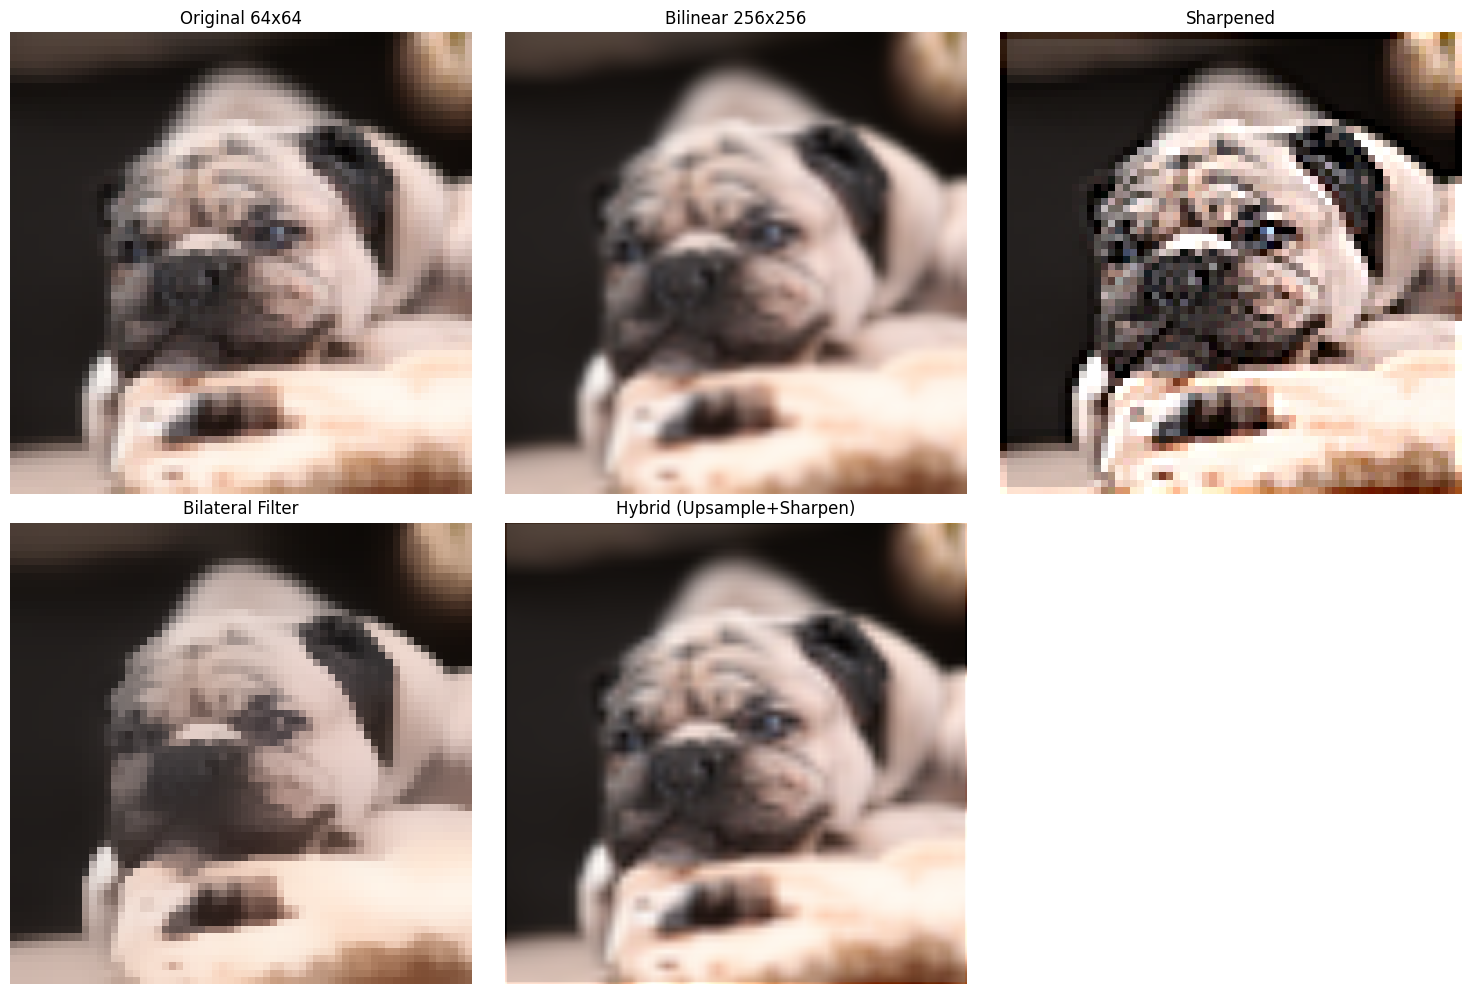

In [39]:
# This cell explores different image enhancement methods applied to the generated base image.
# - It defines configuration including prompt, batch_size, and device.
# - It generates the base 64x64 image similar to the previous cells.
# - It then defines and applies several enhancement methods:
#     - Method 1: Simple Bilinear Upsampling: Uses F.interpolate to upscale the base image to 256x256.
#     - Method 2: Sharpening Filter: Defines a sharpen_image function that applies a simple convolution kernel to sharpen the image.
#     - Method 3: Bilateral Filter (via OpenCV): Defines a bilateral_filter function that uses OpenCV's cv2.bilateralFilter
#       for edge-preserving smoothing. This method requires OpenCV, which might not be installed by default or might cause issues
#       if not handled correctly. The error indicates that cv2 is not defined, suggesting OpenCV is not available or imported
#       properly in this cell's execution context.
#     - Method 4: Hybrid Approach: Combines upsampling and sharpening.
# - It stores the results of each method in a dictionary called methods.
# - It then uses matplotlib.pyplot to create a figure with multiple subplots to display the original image and the results of each enhancement method.
# - The error "name 'cv2' is not defined" in the output confirms the issue with the Bilateral Filter method due to the missing OpenCV import or installation in this cell.
import torch as th
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Configuration
prompt = "sunflower"
batch_size = 1
device = "cuda" if th.cuda.is_available() else "cpu"

# --- 1. BASE IMAGE GENERATION (64x64) ---
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(tokens, options['text_ctx'])

model_kwargs = {
    'tokens': th.tensor([tokens] * batch_size, device=device),
    'mask': th.tensor([mask] * batch_size, dtype=th.bool, device=device)
}

model.del_cache()
base_image = diffusion.p_sample_loop(
    model,
    (batch_size, 3, options['image_size'], options['image_size']),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None
).clamp(-1, 1)
model.del_cache()

# --- 2. ENHANCEMENT METHODS (No External Dependencies) ---

# Method 1: Simple Bilinear Upsampling
upsampled = F.interpolate(base_image, size=256, mode='bilinear', align_corners=False)

# Method 2: Sharpening Filter
def sharpen_image(tensor_img, strength=0.5):
    kernel = th.tensor([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ], dtype=th.float32, device=device).view(1, 1, 3, 3)
    kernel = kernel.repeat(3, 1, 1, 1)  # For RGB channels
    sharpened = F.conv2d(tensor_img, kernel, padding=1, groups=3)
    return (tensor_img + strength * (sharpened - tensor_img)).clamp(-1, 1)

sharpened = sharpen_image(base_image)

# Method 3: Bilateral Filter (via OpenCV)
def bilateral_filter(tensor_img, d=9, sigma_color=75, sigma_space=75):
    img_np = (tensor_img[0].permute(1, 2, 0).cpu().numpy() * 127.5 + 127.5).clip(0, 255).astype(np.uint8)
    filtered = cv2.bilateralFilter(img_np, d, sigma_color, sigma_space)
    return (th.from_numpy(filtered).float().permute(2, 0, 1).unsqueeze(0).to(device) / 127.5 - 1)

filtered = bilateral_filter(base_image)

# Method 4: Hybrid Approach (Upsample + Sharpen)
hybrid = sharpen_image(F.interpolate(base_image, size=256, mode='bilinear'))

# --- 3. DISPLAY RESULTS ---
methods = {
    "Original 64x64": base_image,
    "Bilinear 256x256": upsampled,
    "Sharpened": sharpened,
    "Bilateral Filter": filtered,
    "Hybrid (Upsample+Sharpen)": hybrid
}

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for ax, (title, img) in zip(axes, methods.items()):
    display_img = img[0].permute(1, 2, 0).cpu().clamp(-1, 1)
    ax.imshow(display_img * 0.5 + 0.5)  # Convert to [0,1] for display
    ax.set_title(title)
    ax.axis('off')

# Hide empty subplots
for ax in axes[len(methods):]:
    ax.axis('off')

plt.tight_layout()
plt.show()